# **I. Perkenalan**

***
Milestone 2

Nama  : Catherine Kezia Wijaya
Batch : RMT-037

Notebook ini adalah file utama dari project pembuatan machine learning untuk memprediksi status admisi calon mahasiswa. Notebook berisi perkenalan data, analisis data, pembuatan dan testing model

URL Dataset: https://www.kaggle.com/datasets/taweilo/mba-admission-dataset
***

## Pendahuluan

### Gambaran Data
Dataset ini berisi data sintesis yang dibuat berdasarkan statistik dari calon mahasiswa Wharton Class of 2025. Berikut adalah atribut dari data:
- **application_id**: ID unik calon
- **gender**: Jenis kelamin calon mahasiswa (Male, Female)
- **international**: Status calon sebagai mahasiswa internasional/international student (TRUE/FALSE)
- **gpa**: Grade Point Average (GPA) calon (dalam skala 4.0)
- **major**: Jurusan sarjana (Business, STEM, Humanities)
- **race**: Latar belakang ras pelamar (e.g., White, Black, Asian, Hispanic, Other / null: international student)
- **gmat**: Skor GMA (dalam 800 poin)
- **work_exp**: Jumlah tahun pengalaman kerja(Tahun)
- **work_industry**: Industri tempat bekerja sebelumnya (e.g., Consulting, Finance, Technology, etc.)
- **admission**: Status penerimaan (Admit, Waitlist, Null: Deny)

Data ini sintetis,  sehingga tidak mencerminkan data sebenarnya, tetapi mempunyai pola umum yang ada pada data asli dalam hal distribusi dan hubungan antar variabel.

### Objective
Tujuan utama projek ini adalah membuat model yang bisa memprediksi status admission antara Admit, Deny atau Waitlist, dari calon mahasiswa berdasarkan faktor - faktor pada data. Model ini diharapkan bisa membantu:
- **Calon mahasiswa**: Memberikan pemahaman tentang bagaimana atribut - atribut yang ada (GPA, skor GMAT, pengalaman kerja, dll.)bisa memengaruhi keputusan admission, sehingga di masa depan bisa memahami faktor-faktor apa saja yang bisa meningkatkan peluang mereka diterima.
- **Tim Admission**: Memahami hubungan antara atribut/fitur dan pengaruhnya terhadap kemungkinan mendapat status Admit atau Waiting List, sehingga bisa membantu dalam menyempurnakan strategi perekrutan.
- **Data Scientist/Analyst**: Penggunaan data sintesis dapat menjadi latihan pembuatan model machine learning yang baik untuk tugas-tugas sejenisnya di dunia nyata, seperti dalam pendidikan, HR, atau yang lainnya.

Algoritma model yang dijadikan pertimbangan adalah antara Decision Tree, Logistic Regression, Random Forest, K-Nearest Neighbors, XGBoost Classifier, Gaussian Naive Bayes, dan Support Vector Classificatioin. Performa model dinilai dengan metric Recall, dan nilai evaluasi AUC-ROC

# **II. Import Libraries**

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from scipy.stats import f_oneway, chi2_contingency

from sklearn.model_selection import train_test_split, GridSearchCV

from feature_engine.outliers import Winsorizer

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as imPipeline

from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, roc_auc_score, recall_score

from phik.report import plot_correlation_matrix

import pickle

# **III. Data Loading**

In [2]:
# loading data MBA dan menampilkan data
df_ori = pd.read_csv('MBA.csv')
df = df_ori.copy()
df.head(10)

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN
5,6,Male,False,3.18,Business,White,610.0,6.0,Consulting,NaN
6,7,Female,False,2.93,STEM,Other,590.0,3.0,Technology,Admit
7,8,Male,True,3.02,Business,NaN,630.0,6.0,Financial Services,NaN
8,9,Male,False,3.24,Business,White,590.0,2.0,Nonprofit/Gov,NaN
9,10,Male,False,3.27,Humanities,Asian,690.0,3.0,Consulting,NaN


In [3]:
df.tail(10)

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
6184,6185,Male,False,3.33,STEM,White,620.0,5.0,Health Care,NaN
6185,6186,Male,False,3.19,STEM,Asian,660.0,4.0,Health Care,NaN
6186,6187,Male,True,3.23,Humanities,NaN,610.0,7.0,Financial Services,NaN
6187,6188,Male,False,3.03,Humanities,Asian,570.0,6.0,PE/VC,NaN
6188,6189,Male,False,3.12,STEM,Black,630.0,4.0,Consulting,NaN
6189,6190,Male,False,3.49,Business,White,640.0,5.0,Other,NaN
6190,6191,Male,False,3.18,STEM,Black,670.0,4.0,Consulting,NaN
6191,6192,Female,True,3.22,Business,NaN,680.0,5.0,Health Care,Admit
6192,6193,Male,True,3.36,Business,NaN,590.0,5.0,Other,NaN
6193,6194,Male,False,3.23,STEM,Hispanic,650.0,4.0,Consulting,NaN


In [4]:
# menampilkan rangkuman data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6194 entries, 0 to 6193
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   application_id  6194 non-null   int64  
 1   gender          6194 non-null   object 
 2   international   6194 non-null   bool   
 3   gpa             6194 non-null   float64
 4   major           6194 non-null   object 
 5   race            4352 non-null   object 
 6   gmat            6194 non-null   float64
 7   work_exp        6194 non-null   float64
 8   work_industry   6194 non-null   object 
 9   admission       1000 non-null   object 
dtypes: bool(1), float64(3), int64(1), object(5)
memory usage: 441.7+ KB


- Terdapat 6194 data dengan jumlah fitur 9
- Tipe data untuk setiap kolom sudah benar
- Kolom kategorikal semua bertipe data String atau Boolean, sedangkan untuk numerik tipe data Float atau Integer
- Ada banyak data yang null

`application_id` bersifat redundan karena sudah ada index sendiri dari DataFrame

> Drop kolom `application_id`

In [5]:
# Menghapus kolom application_id
df = df.drop(['application_id'], axis = 1)

>Cek apakah ada data duplikasi

In [6]:
df.duplicated().sum()

30

Semua data sudah unik

>Melihat apa saja fitur pada data

In [7]:
# menampilkan nama kolom pada DataFrame
df.columns

Index(['gender', 'international', 'gpa', 'major', 'race', 'gmat', 'work_exp',
       'work_industry', 'admission'],
      dtype='object')

>Melihat unique value pada semua kolom kategorikal

In [8]:
print('gender: ', df['gender'].unique())
print('international: ', df['international'].unique())
print('major: ', df['major'].unique())
print('race: ', df['race'].unique())
print('work_industry: ', df['work_industry'].unique())
print('admission: ', df['admission'].unique())

gender:  ['Female' 'Male']
international:  [False  True]
major:  ['Business' 'Humanities' 'STEM']
race:  ['Asian' 'Black' nan 'Hispanic' 'White' 'Other']
work_industry:  ['Financial Services' 'Investment Management' 'Technology' 'Consulting'
 'Nonprofit/Gov' 'PE/VC' 'Health Care' 'Investment Banking' 'Other'
 'Retail' 'Energy' 'CPG' 'Real Estate' 'Media/Entertainment']
admission:  ['Admit' nan 'Waitlist']


- Tidak ada whitespace pada data
- Data null terdapat pada kolom `race` dan `admission`

`admission` seharusnya ada 3 tipe value, yaitu Admit, Waitlist, dan Deny, akan tetapi status admission Deny diisi dengan null pada data. Ingin diperiksa kesimbangan data terhadap target.

In [9]:
print('Count Deny: ', df['admission'].isnull().sum())
df['admission'].value_counts()

Count Deny:  5194


admission
Admit       900
Waitlist    100
Name: count, dtype: int64

Terdapat 5194 calon mahasiswa dengan status admission `Deny`, sedangkan terdapat 900 dengan status `Admit` dan 100 untuk `Waitlist`. Jumlah data `Waitlist` terlalu sedikit untuk dianalisa dan dibuat model prediksi terutama jika dibandingkan dengan label lainnya. Karena itu label `Waitlist` dan `Deny` akan digabung menjadi satu label yaitu `Deny or Waitlist`

In [10]:
df['admission'] = df['admission'].str.replace('Waitlist', 'Deny or Waitlist')

# **IV. Exploratory Data Analysis (EDA)**

Berikut adalah statistik deskriptif, cek distribusi untuk variabel bersifat kontinu, dan cek ratio jumlah data untuk variabel bersifat kategorikal

## A. Statistik Deskriptif

### Ringkasan statistik deskriptif data

In [11]:
df.describe()

,gpa,gmat,work_exp
count,6194.000000,6194.000000,6194.000000
mean,3.250714,651.092993,5.016952
std,0.151541,49.294883,1.032432
min,2.650000,570.000000,1.000000
25%,3.150000,610.000000,4.000000
50%,3.250000,650.000000,5.000000
75%,3.350000,680.000000,6.000000
max,3.770000,780.000000,9.000000


- Mayoritas `gpa` calon mahasiswa tinggi, program cukup kompetitif
- Skor `gmat` memiliki nilai standar deviasi 49, nilai ini cukup besar. Dapat disimpulkan nilai GMAT calon mahasiswa bervariasi. Dan juga rata - ratanya bernilai `651`, di atas standar global yang berkisar antara 400 - 600 menurut website __[testmasters](https://www.testmasters.net/GmatAbout/Scoring-Scale#:~:text=While%20total%20scaled%20scores%20range,percentile%20rankings%20assigned%20to%20each.)__
- Kebanyakan calon mahasiswa memiliki pengalaman kerja antara 4-6 tahun. 

### Cek distribusi kolom `gpa`, `gmat`, dan `work_exp`

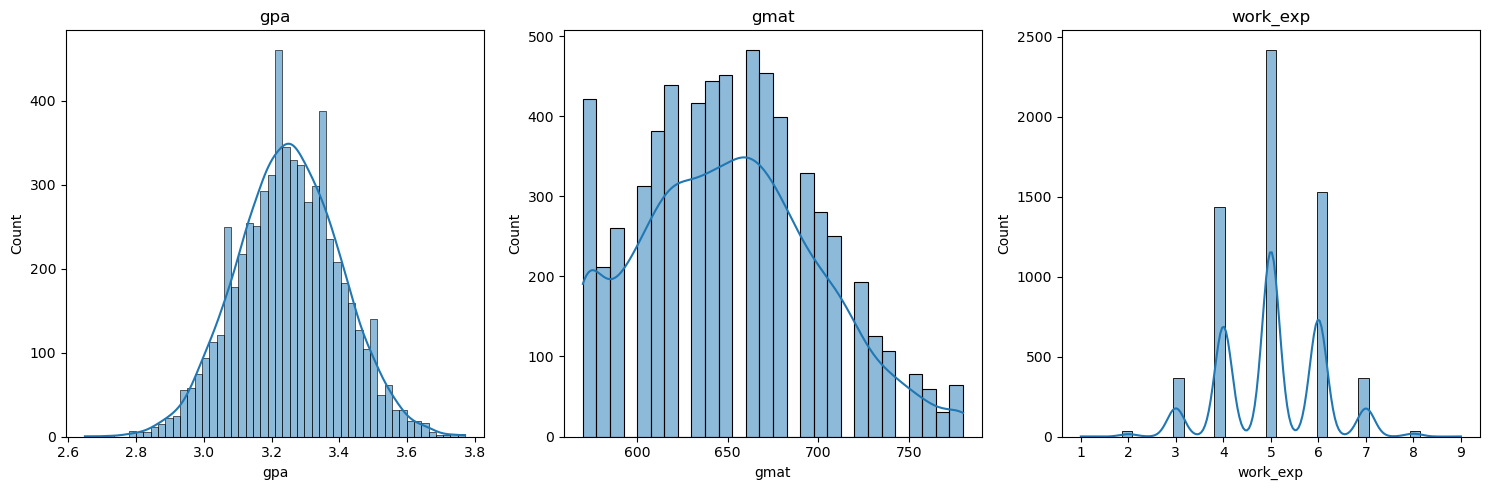

In [12]:
#Melihat distribusi kolom numerik

num_cols = ['gpa', 'gmat', 'work_exp']
# buat figure dan axes
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms with KDE
for i, column in enumerate(num_cols):
    sns.histplot(data=df, x=column, kde=True, ax=axes[i])
    axes[i].set_title(column)

# Display plot
plt.tight_layout()
plt.show()

Semua variabel numerik berdistribusi normal, hanya variabel `gmat` sedikit skewed ke kiri. Disimpulkan nilai GPA, GMAT dan tahun pengalaman kerja mendekati nilai rata - ratanya masing - masing

### Cek ratio kolom `gender`, `international`, `major`, `race`, `work_industry` dan `admission`

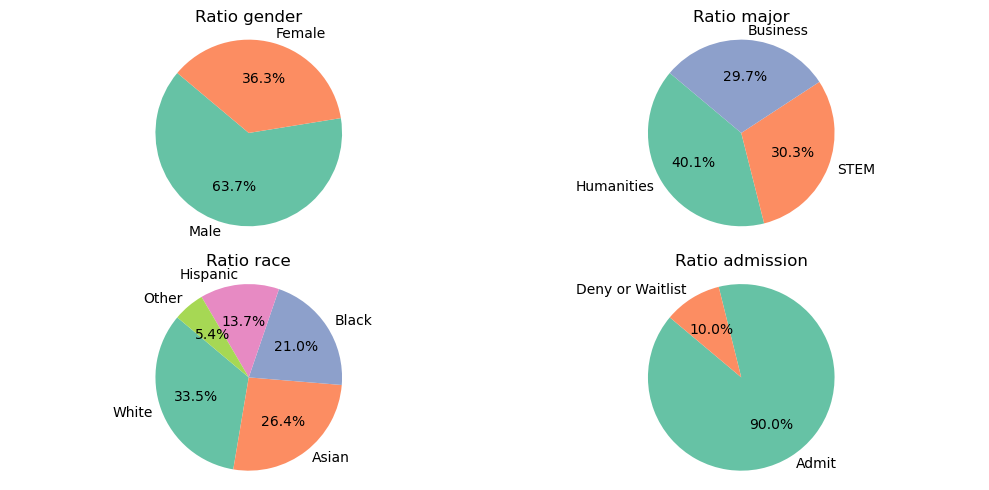

In [13]:
#Melihat ratio kolom kategorikal

pie_cols = ['gender', 'major', 'race', 'admission']
# buat figure dan axes
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 5))
# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, column in enumerate(pie_cols):
    # Hitung jumlah setiap kategori
    category_counts = df[column].value_counts()

    # Plot pie chart
    axes[i].pie(category_counts, labels=category_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2", len(category_counts)))
    axes[i].set_title(f'Ratio {column}')
    axes[i].axis('equal')  # Menjaga agar pie chart berbentuk lingkaran

# Display
plt.tight_layout()
plt.show()

- Calon mahasiswa mayoritas memiliki gender pria, sebanyak 63.7%. Sedangkan untuk wanita hanya sebanyak 36.3% dari seluruh mahasiswa
- Ada 3 `major` yang bisa dipilih mahasiswa, yang paling banyak dipilih adalah `Humanities` sebanyak 40%, diikuti dengan `STEM` sebanyak 30%, dan terakhir adalah `Business` sebanyak 29.7% dari seluruh calon mahasiswa. Jumlah calon mahasiswa setiap major cukup dekat dengan satu sama lain, dan bersifat seimbang
- Ras calon mahasiswa paling banyak adalah `White` sebanyak 33.5%, diikuti dengan `Asian` sebanyak 26.4% dan terakhir `Black` sebanyak 21% dari seluruh calon mahasiswa
- Mayoritas merupakan `Admit` sebanyak 90% dan `Waitlist` hanya 10%, akan tetapi untuk `Deny` masih belum diperhitungkan karena bernilai Null

### Top 5 Background industri pengalaman kerja calon mahasiswa

In [14]:
df['work_industry'].value_counts().head(5)

work_industry
Consulting            1619
PE/VC                  907
Technology             716
Nonprofit/Gov          651
Investment Banking     580
Name: count, dtype: int64

Paling banyak memiliki pengalaman kerja di Consulting sebanyak 1619 calon mahasiswa, diikuti dengan PE/VC, Technology, Nonprofit/Government, dan terakhir Invesment Banking

## B. Statistik Inferensial

### 1. Mana yang berpengaruh lebih besar terhadapt status penerimaan? Nilai GPA atau GMAT?

#### GPA

H0: GPA tidak berpengaruh besar terhadap status penerimaan

H1: GPA berpengaruh besar terhadap status penerimaan

In [15]:
admit_gpa = df[df['admission'] == 'Admit']['gpa']
deny_gpa = df[df['admission'].isnull()]['gpa']
waitlist_gpa = df[df['admission'] == 'Waitlist']['gpa']

f_stat_gpa, p_value_gpa = f_oneway(admit_gpa, waitlist_gpa, deny_gpa)
print("ANOVA GPA: F-stat =", f_stat_gpa, ", p-value =", p_value_gpa)


ANOVA GPA: F-stat = nan , p-value = nan


d:\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4102: DegenerateDataWarning: at least one input has length 0
  if _f_oneway_is_too_small(samples):


- F-stat bernilai 287.416 menunjukkan bahwa ada perbedaan rata-rata GPA yang sangat besar di antara status penerimaan Deny, Admit, dan Waitlist
- P-value sangat kecil, bernilai 4.325e-120 menunjukkan bahwa perbedaan rata - rata terjadi karena ada korelasi yang kuat antara nilai GPA dan status penerimaan

Berhasil tolak H0, Nilai GPA memiliki pengaruh signifikan terhadap status penerimaan.

#### GMAT

H0: GMAT tidak berpengaruh besar terhadap status penerimaan

H1: GMAT kerja berpengaruh besar terhadap status penerimaan

In [16]:
admit_gmat = df[df['admission'] == 'Admit']['gmat']
deny_gmat = df[df['admission'].isnull()]['gmat']
waitlist_gmat = df[df['admission'] == 'Waitlist']['gmat']

f_stat_gmat, p_value_gmat = f_oneway(admit_gmat, waitlist_gmat, deny_gmat)
print("ANOVA Work Experience: F-stat =", f_stat_gmat, ", p-value =", p_value_gmat)

ANOVA Work Experience: F-stat = nan , p-value = nan


- F-stat bernilai 451.35 menunjukkan bahwa ada perbedaan rata-rata GMAT yang sangat besar di antara kelompok status penerimaan Deny, Admit, dan Waitlist
- P-value sangat kecil, bernilai 1.041e-183 menunjukkan bahwa perbedaan rata - rata terjadi karena ada korelasi yang kuat antara nilai GMAT dan status penerimaan

Berhasil tolak H0, Nilai GMAT memiliki pengaruh signifikan terhadap status penerimaan.

- GPA
    - F-stat: 287.416
    - p-value = 4.325e-120
- GMAT
    - F-stat: 451.352
    - p-value = 1.041e-183

Dari analisis ANOVA ini, GMAT terbukti memiliki pengaruh lebih besar terhadap status penerimaan dibandingkan dengan GPA.

### 2. Apakah pengalaman pekerjaan industri calon mahasiswa mempengaruhi jurusan yang dipilih?

H0: Tidak ada hubungan antara `work_industry` dan `major`.

H1: Ada hubungan antara `work_industry` dan `major`.

In [17]:
contingency_table = pd.crosstab(df['work_industry'], df['major'])

# Uji Chi-Square
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-Square: {chi2}")
print(f"p-value: {p_value}")

Chi-Square: 21.68781447790691
p-value: 0.7056503903537901


- Nilai 21.68 pada Chi-Square menunjukkan adanya beberapa perbedaan dalam distribusi `work_industry` terhadap `major`
- p-value 0.7056 jauh lebih besar dari 0.05, menunjukkan bahwa gagal tolak h0, tidak ada hubungan yang signifikan antara `work_exp` calon mahasiswa dengan `major` yang mereka pilih.

# **V. Feature Engineering**

## Split antara X (Features) and y (target)

Pisah antara target (kolom `admission`) dengan kolom lainnya

In [18]:
#Splitting between 'X' and 'y'
X = df.drop(['admission'], axis = 1)
y = df['admission']
X

,gender,international,gpa,major,race,gmat,work_exp,work_industry
0,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services
1,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management
2,Female,True,3.30,Business,NaN,710.0,5.0,Technology
3,Male,False,3.47,STEM,Black,690.0,6.0,Technology
4,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting
...,...,...,...,...,...,...,...,...
6189,Male,False,3.49,Business,White,640.0,5.0,Other
6190,Male,False,3.18,STEM,Black,670.0,4.0,Consulting
6191,Female,True,3.22,Business,NaN,680.0,5.0,Health Care
6192,Male,True,3.36,Business,NaN,590.0,5.0,Other


In [19]:
# dataset y
y

0       Admit
1         NaN
2       Admit
3         NaN
4         NaN
        ...  
6189      NaN
6190      NaN
6191    Admit
6192      NaN
6193      NaN
Name: admission, Length: 6194, dtype: object

Admission status menjadi target, dipisah dari data dan disimpan pada variabel y

## Splitting between Train-Set and Test-set

Variabel X dipisah menjadi data Train dan data Test

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)
print('Train Size: ', X_train.shape)
print('Test Size: ', X_test.shape)

Train Size:  (4955, 8)
Test Size:  (1239, 8)


## Handling Missing Value

Periksa, analisis dan menghilangkan Missing Value dari data

In [21]:
# Melihat nilai null pada setiap X_train
X_train.isnull().sum()

gender              0
international       0
gpa                 0
major               0
race             1476
gmat                0
work_exp            0
work_industry       0
dtype: int64

In [22]:
# Melihat nilai null pada setiap X_test
X_test.isnull().sum()

gender             0
international      0
gpa                0
major              0
race             366
gmat               0
work_exp           0
work_industry      0
dtype: int64

Terdapat banyak missing value di kolom `race`. Ingin dianalisis apakah Missing Value ini termasuk MCAR (Missing Completely at Random), MAR (Missing at Random), atau MNAR (Missing Not at Random). Dari yang sudah dijabarkan di bagian [Gambaran Data](#gambaran-data), `race`yang bernilai null adalah International Student.

In [23]:
X_train[X_train['international'] == True]

,gender,international,gpa,major,race,gmat,work_exp,work_industry
1020,Female,True,3.25,Humanities,NaN,670.0,3.0,Consulting
1894,Male,True,3.33,Business,NaN,680.0,4.0,Financial Services
2226,Female,True,3.22,Business,NaN,660.0,4.0,Nonprofit/Gov
5451,Male,True,3.26,Humanities,NaN,700.0,5.0,Health Care
911,Male,True,3.41,STEM,NaN,710.0,6.0,Nonprofit/Gov
...,...,...,...,...,...,...,...,...
5051,Female,True,3.37,STEM,NaN,740.0,6.0,PE/VC
5311,Female,True,3.27,Humanities,NaN,680.0,5.0,Investment Banking
1685,Female,True,3.13,Business,NaN,640.0,5.0,CPG
4426,Male,True,3.39,Business,NaN,650.0,4.0,Nonprofit/Gov


In [24]:
X_train[(X_train['international'] == True) & (X_train['race'].notnull())]

,gender,international,gpa,major,race,gmat,work_exp,work_industry


Terlihat bahwa semua calon mahasiswa dengan status `international` **True** memiliki nilai **NaN** pada kolom `race`. Missing value ini bertipe MAR. Maka, semua missing value pada kolom `race` akan diisi dengan **International Student**

In [25]:
# isi missing value kolom race dengan Undisclosed

X_train['race'] = X_train['race'].fillna('International Student')
X_test['race'] = X_test['race'].fillna('International Student')

In [26]:
# Melihat nilai null pada setiap y_train
y_train.isnull().sum()

4169

In [27]:
# Melihat nilai null pada setiap y_test
y_test.isnull().sum()

1025

Sesuai dengan [Gambaran Data](#gambaran-data), nilai null menandakan bahwa calon mahasiswa telah ditolak. Missing value di tabel `y` akan diisi dengan `Deny`

In [28]:
y_train = y_train.fillna('Deny or Waitlist')
y_test = y_test.fillna('Deny or Waitlist')

Pastikan lagi apakah sudah tidak ada Missing Value

In [29]:
X_train.isnull().sum()

gender           0
international    0
gpa              0
major            0
race             0
gmat             0
work_exp         0
work_industry    0
dtype: int64

In [30]:
X_test.isnull().sum()

gender           0
international    0
gpa              0
major            0
race             0
gmat             0
work_exp         0
work_industry    0
dtype: int64

In [31]:
y_train.isnull().sum()

0

In [32]:
y_test.isnull().sum()

0

Sudah tidak ada Missing Value pada data

## **Cardinality**

Analisis dan handling (jika perlu) cardinality kolom yang bersifat kategorikal.

Pertama - tama hitung cardinality setiap kolom

In [33]:
obj_col = X_train.select_dtypes(include=['object'])
for cat in obj_col:
  count = len(X_train[cat].unique())
  print(f"Cardinality of column {cat} is {count}")

Cardinality of column gender is 2
Cardinality of column major is 3
Cardinality of column race is 6
Cardinality of column work_industry is 14


Tidak ada nilai cardinality yang terlalu besar, tidak perlu ada perubahan data

## Handling Outlier

Identifikasi dan pengelolaan outliers dari distribusi data

>Cek skewness setiap variabel data yang bersifat numerik

In [34]:
X_train.columns

Index(['gender', 'international', 'gpa', 'major', 'race', 'gmat', 'work_exp',
       'work_industry'],
      dtype='object')

In [35]:
num_col = ['gpa', 'gmat', 'work_exp']
X_train[num_col].skew()

gpa        -0.014846
gmat        0.307506
work_exp   -0.029538
dtype: float64

Semua kolom numerik memiliki nilai skewness sangat kecil, kurang dari 0.5, berarti semua data berdistribusi normal. Selanjutnya periksa persentase outlier dari setiap variabel

In [36]:
# Membuat fungsi untuk menghitung persentase outlier pada variabel berdistribusi normal
def calculate_outlier_percentages_normal(df, columns, threshold=3):
    for variable in columns:
        mean = df[variable].mean()
        std = df[variable].std()

        z = (df[variable] - mean) / std
        outliers = df[np.abs(z) > threshold]
        
        outlier_percentage = len(outliers) / len(df) * 100

        print(f'Percentage of outliers in {variable}: {outlier_percentage:.2f}%')

In [37]:
calculate_outlier_percentages_normal(X_train, num_col)

Percentage of outliers in gpa: 0.30%
Percentage of outliers in gmat: 0.00%
Percentage of outliers in work_exp: 0.06%


Terdapat sedikit outlier pada kolom `gpa` dan `work_exp`, jauh di bawah 1%. Tidak ada outlier pada kolom `gmat`. Kolom `gpa` dan `work_exp` akan dicapping outlier-nya dengan Winsorizer

In [38]:
winsorisernormal = Winsorizer(capping_method='gaussian', # choose gaussian for mean and std
                          tail='both', # cap left, right or both tails
                          fold=1.5,
                          variables=['gpa', 'work_exp'])

winsorisernormal.fit(X_train)
X_train = winsorisernormal.transform(X_train)

>Periksa lagi apakah outlier sudah hilang

In [39]:
calculate_outlier_percentages_normal(X_train, num_col)

Percentage of outliers in gpa: 0.00%
Percentage of outliers in gmat: 0.00%
Percentage of outliers in work_exp: 0.00%


Sudah tidak ada outlier pada data

## Feature Selection

Memeriksa korelasi setiap variabel dengan target dan mengolah data dengan memeriksa korelasi setiap variabel terhadap target

In [40]:
# Menggabungkan X_train and y_train
feature_select = pd.concat([X_train, y_train], axis=1)

# DataFrame
feature_select.head()

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
6189,Male,False,3.477756,Business,White,640.0,5.000000,Other,Deny or Waitlist
711,Female,False,3.477756,Humanities,Other,690.0,4.000000,Consulting,Admit
3954,Female,False,3.430000,STEM,Asian,660.0,4.000000,Consulting,Admit
1020,Female,True,3.250000,Humanities,International Student,670.0,3.477609,Consulting,Admit
5726,Male,False,3.160000,Business,Asian,640.0,5.000000,Retail,Deny or Waitlist


>Menggunakan PhiK untuk menghitung korelasi variabel dengan target

interval columns not set, guessing: ['gpa', 'gmat', 'work_exp']


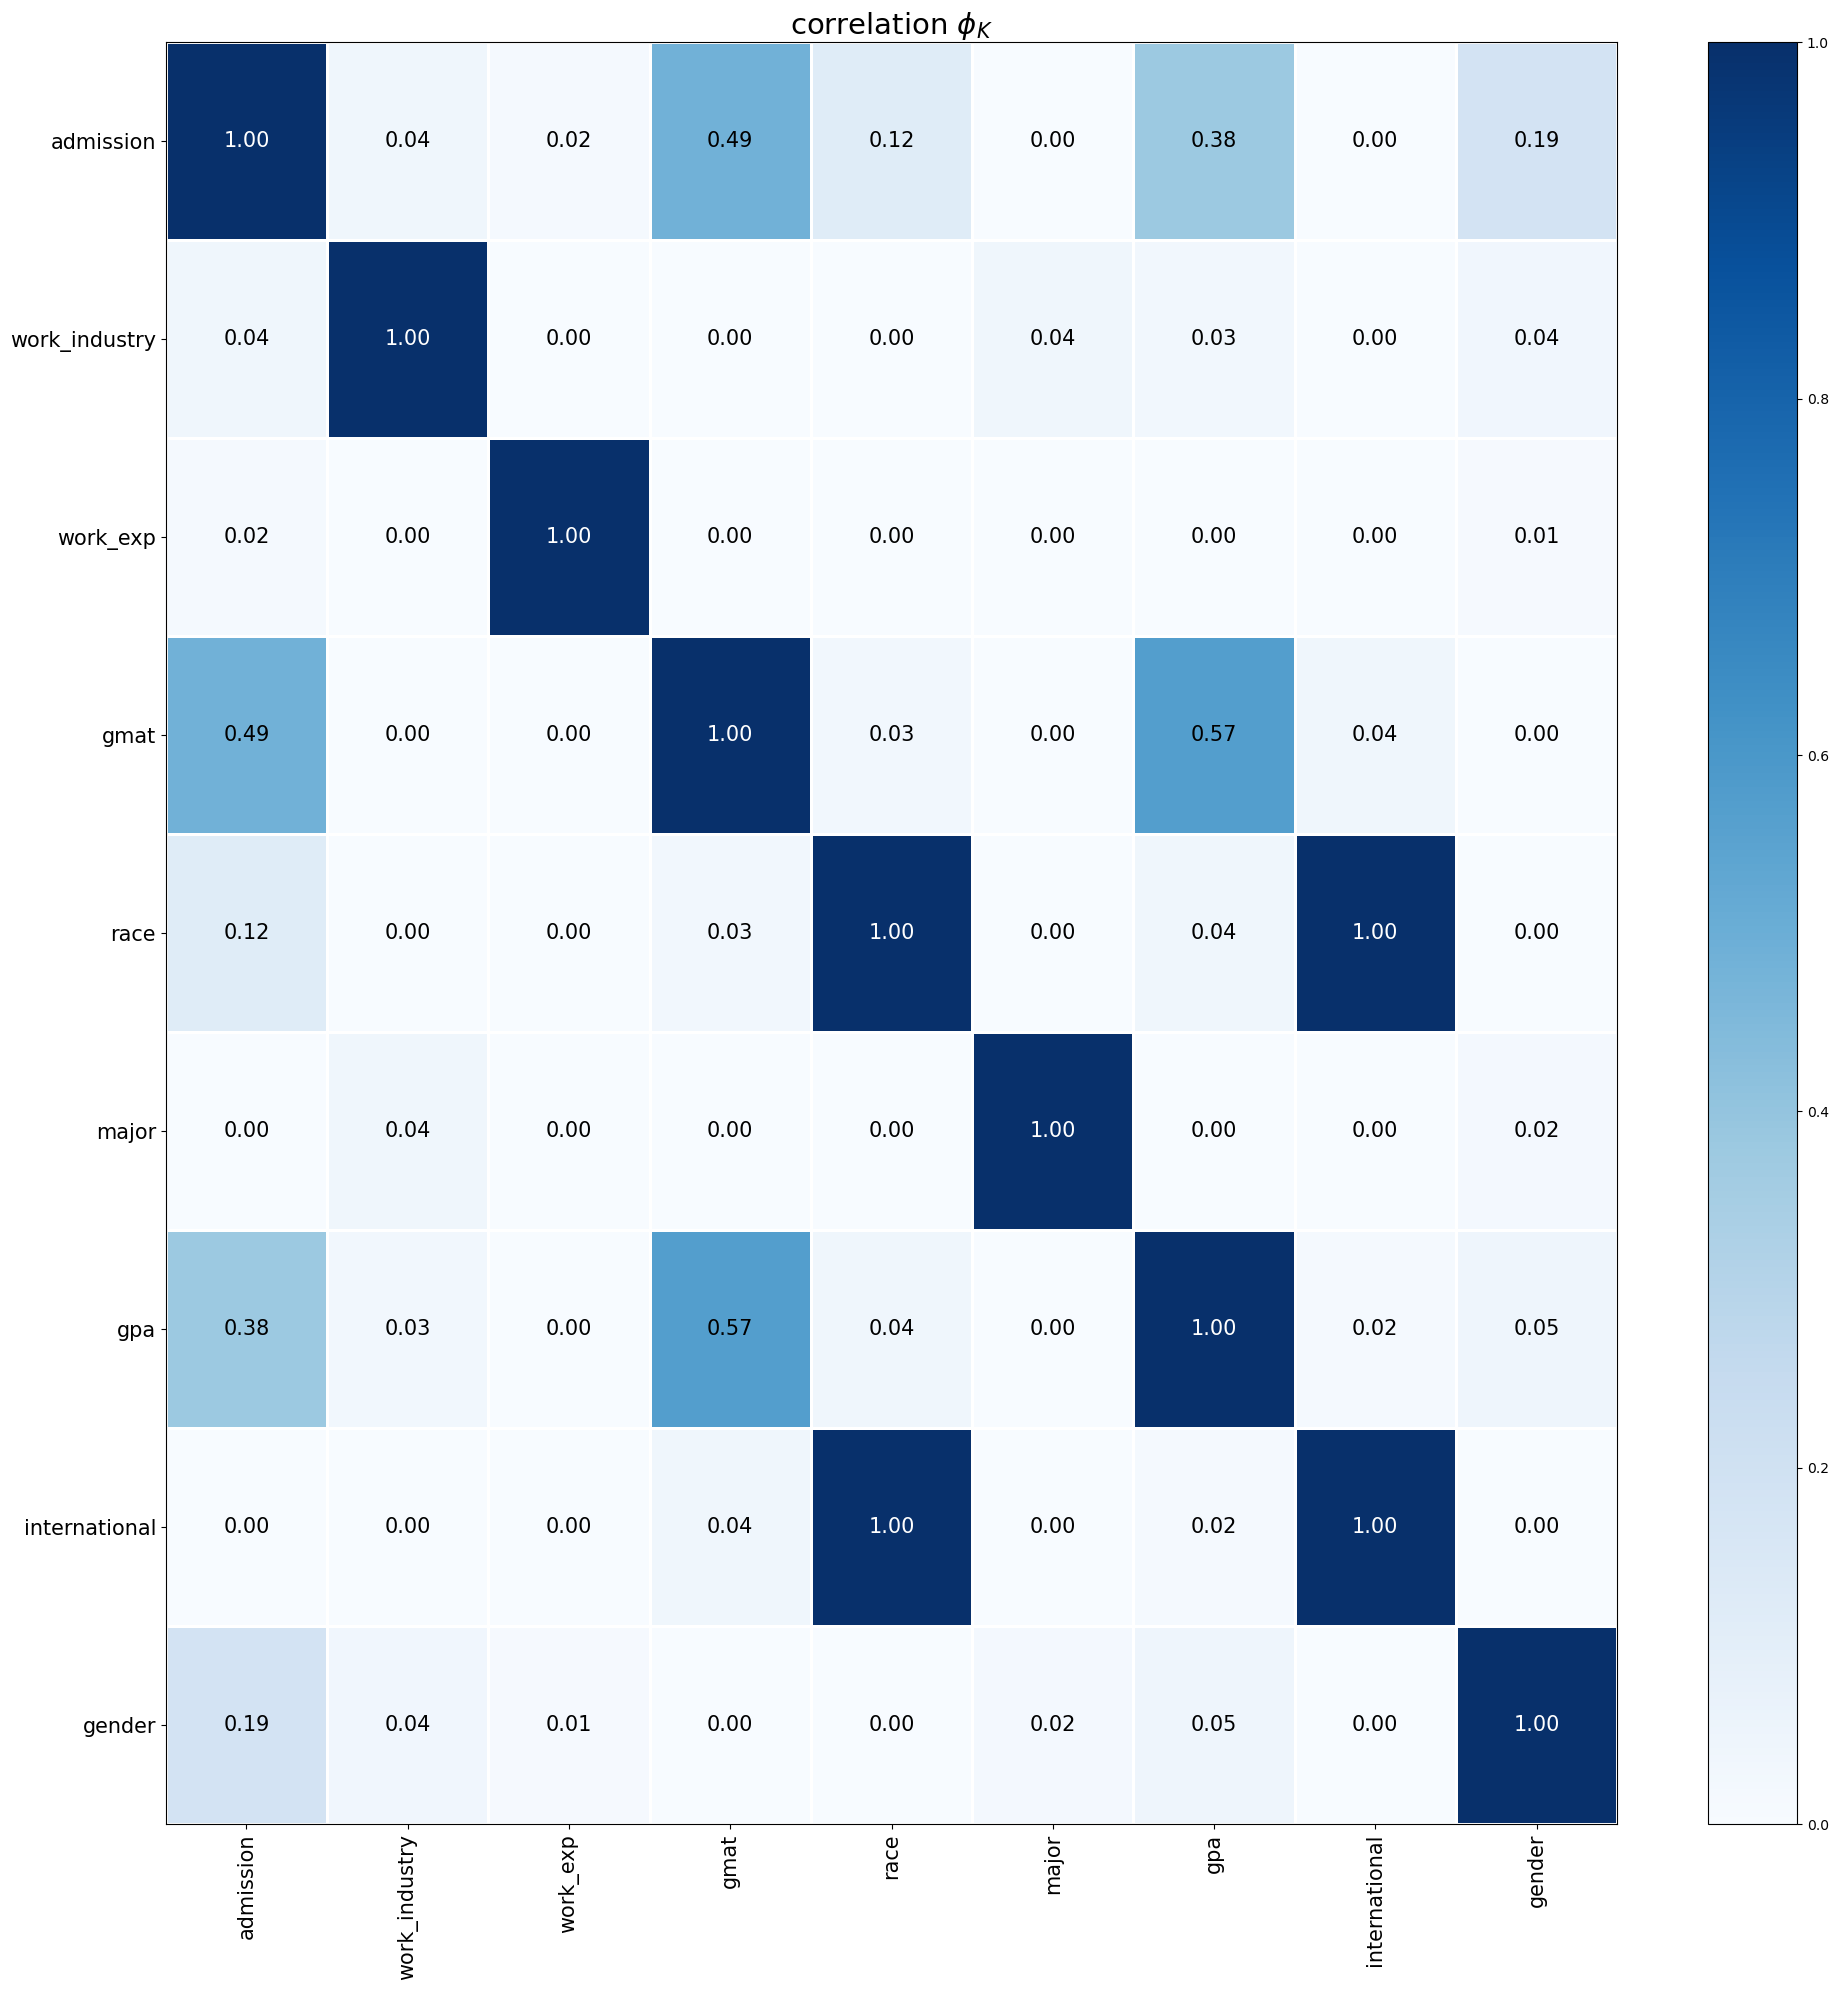

In [41]:
# Create function to correlate variables with default
def compute_phik_correlation(dataframe, columns):
    subset = dataframe[columns]
    correlation_matrix = subset.phik_matrix()
    return correlation_matrix

# Define the list of columns for each subset
columns = feature_select.columns.tolist()

# Compute Phi-K correlation for each set of columns and print
correlation = compute_phik_correlation(feature_select, columns)

plot_correlation_matrix(correlation.values, x_labels=correlation.columns, y_labels=correlation.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(20,20))
plt.tight_layout()

Nilai korelasi setiap variabel terhadap target termasuk kecil, dengan nilai tertinggi sebesar 0.41 pada kolom `gmat`. Dari nilai - nilai korelasi ini, akan dibuang variabel dengan nilai **terlalu kecil**, yaitu yang kurang dari **0.1**, yaitu `work_industry`, `work_exp`, `major`, `international`

In [42]:
#Drop column that < 0.1
X_train.drop(['work_industry', 'work_exp', 'major', 'international'], axis = 1, inplace = True)
X_test.drop(['work_industry', 'work_exp', 'major', 'international'], axis = 1, inplace = True)
X_train

,gender,gpa,race,gmat
6189,Male,3.477756,White,640.0
711,Female,3.477756,Other,690.0
3954,Female,3.430000,Asian,660.0
1020,Female,3.250000,International Student,670.0
5726,Male,3.160000,Asian,640.0
...,...,...,...,...
3772,Female,3.250000,Black,640.0
5191,Male,3.260000,Other,650.0
5226,Male,3.270000,International Student,660.0
5390,Male,3.240000,Asian,570.0


## Column Transformer

Bagian ini adalah proses untuk men-scaling data numerik dan encoding data kategorikal

Dari analisis sebelumnya di bagian [Handling Outlier](#handling-outlier), ditemukan bahwa semua data numerik berdistribusi normal, maka proses scaling akan menggunakan **Standard Scaler**. Untuk data kategorikal menggunakan **OneHotEncoding**. Karena kolom `race` bisa diisi kosong maka dibuat Pipeline supaya model bisa meng-handle missing value ini

In [43]:
# Pipeline untuk kolom 'race'
race_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='International Student')),
    ('encoder', OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# ColumnTransformer
transformer = ColumnTransformer([
    ('race_processing', race_pipeline, ['race']),
    ('scaler', StandardScaler(), ['gpa', 'gmat']),
    ('encoder_gender', OneHotEncoder(handle_unknown="ignore", sparse_output=False), ['gender']),
], remainder='passthrough')

Target juga diencoding, menggunakan Label Encoder

In [44]:
#### Encode target
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# **VI. Model Definition**

Model yang dianggap cocok untuk data ini adalah:
- **Decision Tree**: Mudah dipahami, bisa dilihat secara langsung bagaimana keputusan diambil pada setiap titik percabangan (node). Dapat menangani variabel numerik dan kategorikal

- **Logistic Regression**: Mudah untuk diinterpretasikan dan memberikan hasil yang jelas. Model sangat efektif jika hubungan antara fitur dan target bersifat linier.

- **Random Forest**: Model yang bisa bekerja dengan baik pada dataset dengan banyak fitur dan interaksi kompleks antar variabel.

- **K-Nearest Neighbors**: Bekerja lebih baik dengan dataset kecil hingga sedang karena sifatnya yang memerlukan komputasi jarak antar data untuk setiap prediksi, sangat sensitif terhadap skala fitur

- **XGBoost**: Algoritma boosting yang menggabungkan banyak model sederhana (Decision Tree) untuk menghasilkan prediksi yang lebih kuat, dapat menangani data numerik dan kategorikal dengan baik, cocok untuk dataset yang lebih besar dan kompleks.

- **Gaussian Naive Bayes**: Cocok untuk data dengan jumlah fitur yang besar, cepat untuk dilatih dan diinferensikan, dapat menangani variabel kontinu dengan asumsi distribusi normal, cenderung tidak overfitting.

- **Support Vector Classification**: melakukan klasifikasi data dengan cara memisahkan kelas-kelas dalam data dengan margin terbesar. Dapat menangani data non-linier, robust terhadap overfitting

Hyperparameter: Menggunakan GridSearchCV

Dibuat model dan dianalisa performanya dengan metric:
- **AUC-ROC**: mengevaluasi kemampuan model dalam membedakan antara kelas.

- Prioritas **Recall**: Mengukur kemampuan model untuk mendeteksi semua positif, yaitu, berapa banyak kandidat yang benar-benar diterima dapat terdeteksi dengan benar. Dalam konteks penerimaan universitas, akan lebih berisiko untuk menolak calon yang seharusnya diterima daripada menerima calon yang sebenarnya tidak memenuhi syarat. Calon yang sangat potensial namun tidak diterima bisa merasa sangat dirugikan, dan hal ini bisa mengurangi reputasi universitas.

# **VII. Model Training**

## A. Base Model Evaluation

Pertama - tama ingin menentukan Base Model yang tepat. Buat Pipeline untuk semua model

### Pipeline

In [45]:
#Making pipeline for LogReg
pipe_logreg = Pipeline([
('transformer', transformer),
('classifier', LogisticRegression(max_iter=1000000))
])

#Making pipeline for Decision Tree
pipe_dt = Pipeline([
('transformer', transformer),
('classifier', DecisionTreeClassifier(random_state=10))
])

#Making pipeline for Random Forest
pipe_rf = Pipeline([
('transformer', transformer),
('classifier', RandomForestClassifier(random_state=10))
])

#Making pipeline for KNN
pipe_knn = Pipeline([
('transformer', transformer),
('classifier', KNeighborsClassifier())
])

#Making pipeline for SVC
pipe_gnb = Pipeline([
('transformer', transformer),
('classifier', GaussianNB())
])

#Making pipeline for XGBoost
pipe_xgb = Pipeline([
('transformer', transformer),
('classifier', XGBClassifier())
])

pipe_svc = Pipeline([
('transformer', transformer),
('classifier', SVC())
])

### AUC Score

Menampilkan nilai AUC Score untuk semua model

In [46]:
def evaluate_auc_pipelines(pipelines, X_train, X_test, y_train, y_test):
    results = []
    for name, pipeline in pipelines.items():
        # Fit pipeline ke data training
        pipeline.fit(X_train, y_train)
        
        # Prediksi probabilitas untuk menghitung AUC
        y_pred_train = pipeline.predict(X_train)
        y_pred_test = pipeline.predict(X_test)
        
        # Hitung AUC untuk train dan test
        auc_train = roc_auc_score(y_train, y_pred_train)
        auc_test = roc_auc_score(y_test, y_pred_test)
        
        results.append((name, auc_train, auc_test))
        
    # Tampilkan hasil
    results_df = pd.DataFrame(results, columns=['Model', 'AUC Train', 'AUC Test'])
    
    # Display the DataFrame
    print(results_df)
    
    return results

In [47]:
pipelines = {
    'Logistic Regression': pipe_logreg,
    'Decision Tree': pipe_dt,
    'Random Forest': pipe_rf,
    'KNN': pipe_knn,
    'GaussianNB': pipe_gnb,
    'XGBoost': pipe_xgb,
    'SVC': pipe_svc
}

# Panggil fungsi evaluate_pipelines
results = evaluate_auc_pipelines(pipelines, X_train, X_test, y_train, y_test)

                 Model  AUC Train  AUC Test
0  Logistic Regression   0.552285  0.558965
1        Decision Tree   0.914433  0.577027
2        Random Forest   0.847468  0.568450
3                  KNN   0.679095  0.586495
4           GaussianNB   0.634309  0.613889
5              XGBoost   0.721889  0.558451
6                  SVC   0.504619  0.500000


- **GaussianNB** memiliki performa paling konsisten dan terbaik pada data test (AUC test: 0.6139). Hal ini menunjukkan model ini cocok untuk dataset dengan pola sederhana ini.

- **Decision Tree** dan **Random Forest** cenderung overfit, Skor AUC test turun drastis dari Skor AUC train, tidak cocok untuk dataset ini tanpa tuning lebih lanjut.

- **KNN** menunjukkan hasil cukup stabil, tapi performanya masih di bawah **GaussianNB**.

- **KNN** skor AUC untuk data train dan test relatif dekat, dengan sedikit performa generalisasi yang lebih baik dibandingkan model lain. Model tidak terlalu overfitting, tetapi performanya masih kurang optimal.

- **XGBoost** tidak optimal meskipun memiliki potensi

- **Logistic Regression** dan **SVC** memiliki performa yang terlalu rendah, bersifat underfitting karena nilai AUC yang rendah

Model terbaik dari penilaian skor AUC adalah **GaussianNB**, dikarenakan perbedaan antara skor training dan skor testing yang relatif kecil, dan juga memiliki skor testing yang lebih tinggi dari model lainnya, yaitu 0.61

### Classification Report

Menggunakan metric recall saja

In [48]:
def evaluate_classification_report(pipelines, X_train, X_test, y_train, y_test):

    for name, pipeline in pipelines.items():
        print(f"Analisis: {name}")
        
        # Fit pipeline ke data training
        pipeline.fit(X_train, y_train)
        
        # Prediksi label
        y_pred_test = pipeline.predict(X_test)
        
        # Classification report
        label = ['Admit', 'Deny or Waitlist']
        report_test = classification_report(y_test, y_pred_test, zero_division=0, target_names=label)
        
        print(f"Classification Report - Test:\n{report_test}")
        print("-" * 50)

In [49]:
# Evaluasi Classification Report
print("\nEvaluating Classification Reports:")
evaluate_classification_report(pipelines, X_train, X_test, y_train, y_test)


Evaluating Classification Reports:
Analisis: Logistic Regression
Classification Report - Test:
                  precision    recall  f1-score   support

           Admit       0.52      0.14      0.22       196
Deny or Waitlist       0.86      0.98      0.91      1043

        accuracy                           0.84      1239
       macro avg       0.69      0.56      0.57      1239
    weighted avg       0.80      0.84      0.80      1239

--------------------------------------------------
Analisis: Decision Tree
Classification Report - Test:
                  precision    recall  f1-score   support

           Admit       0.29      0.28      0.29       196
Deny or Waitlist       0.87      0.87      0.87      1043

        accuracy                           0.78      1239
       macro avg       0.58      0.58      0.58      1239
    weighted avg       0.78      0.78      0.78      1239

--------------------------------------------------
Analisis: Random Forest
Classification Report 

- Semua model memiliki recall yang relatif tinggi untuk kelas Deny or Waitlist, yaitu sekitar 0.86-0.98, menunjukkan bahwa model-model ini cukup baik dalam mendeteksi kelas Deny or Waitlist dan menghindari false negatives untuk kelas tersebut.

- Model-model seperti Logistic Regression (0.14), Random Forest (0.23), XGBoost (0.17) dan SVC (0) memiliki recall yang rendah untuk kelas Admit. Menunjukkan bahwa model-model ini cenderung mengklasifikasikan sebagian besar data testing kelas Admit sebagai kelas Deny or Waitlist, menghasilkan banyak false positives. Decision Tree, GaussianNB, dan KNN memiliki recall sedikit lebih baik untuk kelas Admit, yaitu sekitar 0.24-0.33, meskipun masih dianggap cukup rendah.

- Semua model menunjukkan hasil yang sangat tidak seimbang antara kelas Admit dan kelas Deny or Waitlist, dengan kelas Deny or Waitlist selalu mendapatkan recall yang sangat baik, tetapi kelas Admit seringkali terabaikan. Hal ini disebabkan oleh ketidakseimbangan dalam jumlah data. Dapat dilihat dari data test ini, antara kelas Admit yang berjumlah 196 dan kelas Deny or Waitlist yang berjumlah 1043.

Dari analisis Classification Report, model terbaik diambil dari nilai rata - rata recall weighted, karena data tidak seimbang maka perlu ditambah nilai bobot yang sesuai untuk setiap kelas pada data, dan juga nilai recall untuk setiap kelas. Didapat bahwa Logistic Regression dan SVC adalah model terbaik dengan weighted recall 0.84, akan tetapi Logistic Regression memiliki precision kelas 0 yang lebiih tinggi dari SVC, maka model terbaik adalah Logistic Regression

### Cross Validation

Melakukan Cross Validation untuk memeriksa performa model. Karena data tidak seimbang, scoring menggunakan metric recall_weighted

In [50]:
def evaluate_cross_validation(pipelines, X, y, cv, scoring):
    results = []
    best_pipeline = None
    best_score = 0
    
    # Loop through each pipeline
    for name, pipeline in pipelines.items():
        print(f"Analisis: {name}")
        scores = cross_val_score(pipeline, X, y, cv=cv, scoring=scoring)
        
        # Calculate statistics
        mean_score = scores.mean()
        std_score = scores.std()
        range_score = (mean_score - std_score, mean_score + std_score)
        
        # Store results for table display
        results.append((name, mean_score, std_score, range_score[0], range_score[1]))
        
        # Display results
        print(f"{scoring} - All - Cross Validation  : {scores}")
        print(f"{scoring} - Mean - Cross Validation : {mean_score:.4f}")
        print(f"{scoring} - Std - Cross Validation  : {std_score:.4f}")
        print(f"{scoring} - Range of Test-Set       : {range_score[0]:.4f} - {range_score[1]:.4f}")
        print("-" * 50)
        
        # Update the best model if needed
        if mean_score > best_score:
            best_score = mean_score
            best_pipeline = name

    # Display the table with the mean scores
    results_df = pd.DataFrame(results, columns=['Model', f'{scoring.capitalize()} Mean', f'{scoring.capitalize()} Std', 'Range Lower', 'Range Upper'])
    print("\nCross-Validation Results:")
    print(results_df)
    
    # Display best model
    print(f"\nBest Model: {best_pipeline}")
    print(f"Best {scoring.capitalize()} Score: {best_score:.4f}")
    
    return results_df
        


In [51]:
skfold = StratifiedKFold(n_splits=5)

evaluate_cross_validation(pipelines, X_train, y_train, cv=skfold, scoring="recall")

Analisis: Logistic Regression
recall - All - Cross Validation  : [0.97884841 0.97058824 0.97882353 0.96823529 0.96941176]
recall - Mean - Cross Validation : 0.9732
recall - Std - Cross Validation  : 0.0047
recall - Range of Test-Set       : 0.9685 - 0.9779
--------------------------------------------------
Analisis: Decision Tree
recall - All - Cross Validation  : [0.87426557 0.88352941 0.89647059 0.85529412 0.86      ]
recall - Mean - Cross Validation : 0.8739
recall - Std - Cross Validation  : 0.0151
recall - Range of Test-Set       : 0.8588 - 0.8890
--------------------------------------------------
Analisis: Random Forest
recall - All - Cross Validation  : [0.92361927 0.91764706 0.92941176 0.89058824 0.91411765]
recall - Mean - Cross Validation : 0.9151
recall - Std - Cross Validation  : 0.0133
recall - Range of Test-Set       : 0.9018 - 0.9284
--------------------------------------------------
Analisis: KNN
recall - All - Cross Validation  : [0.94594595 0.92705882 0.94823529 0.922

,Model,Recall Mean,Recall Std,Range Lower,Range Upper
0,Logistic Regression,0.973181,0.004676,0.968505,0.977858
1,Decision Tree,0.873912,0.015111,0.858801,0.889023
2,Random Forest,0.915077,0.013309,0.901768,0.928386
3,KNN,0.936954,0.010364,0.926590,0.947318
4,GaussianNB,0.902138,0.009532,0.892606,0.911671
5,XGBoost,0.935780,0.009429,0.926351,0.945209
6,SVC,0.998824,0.001487,0.997338,1.000311


Dari Proses Cross Validation, diambil model dengan rata - rata skor tertinggi, yaitu SVC dengan hasil Mean Cross Validation recall 0.9988

Dari ketiga proses analisis ini, yang diutamakan adalah hasil analisis **classification report** karena:
- Dari semua analisis, classification report mempertimbangkan keseimbangan data, dan juga menunjukkan nilai precision yang tidak hanya keseluruhan tetapi juga untuk setiap kelas. Dari kedua pertimbangan ini ditemukan Logistic Regression terbaik
- Meskipun nilai mean cross validation paling tinggi pada model SVC yang bernilai 0.99, Logistic Regression memiliki nilai kedua tertinggi yaitu 0.97, hanya ada 2% perbedaan. Pemilihan model Logistic Regression masih valid.

Jadi, model yang dipilih adalah Logistic Regression. Berikut tampilan model Logistic Regression dan evaluasinya

### Model Evaluation before tuning

In [52]:
pipe_logreg.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('race_processing',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='International '
                                                                                            'Student',
                                                                                 strategy='constant')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['race']),
                                                 ('scaler', StandardScaler(),
                                                  ['gpa', 'gmat']),
                                                 ('encoder_gender',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['gender'])])),
                ('classifier', LogisticRegression(max_iter=1000000))])

In [53]:
# Get predictions for both training and test data
y_pred_train = pipe_logreg.predict(X_train)
y_pred_test = pipe_logreg.predict(X_test)

# Print auc score
print('AUC Score - Train Set  : ', roc_auc_score(y_train, y_pred_train))
print('AUC Score - Test Set   : ', roc_auc_score(y_test, y_pred_test))

AUC Score - Train Set  :  0.5522851575030475
AUC Score - Test Set   :  0.5589645254074784


Nilai AUC rendah menunjukkan bahwa model kurang baik dalam membedakan antara dua kelas (0 dan 1). Hal ini bisa jadi karena distribusi data yang tidak seimbang, sehingga model lebih bias terhadap kelas mayoritas.

In [54]:
# Print recall score
print('recall Score - Train Set : ', recall_score(y_train, y_pred_train))
print('recall Score - Test Set : ', recall_score(y_test, y_pred_test))

recall Score - Train Set :  0.9738884968242767
recall Score - Test Set :  0.975071907957814


Skor recall sangat tinggi, dan nilai relatif sama

In [55]:
print(classification_report(y_test, pipe_logreg.predict(X_test)))

              precision    recall  f1-score   support

           0       0.52      0.14      0.22       196
           1       0.86      0.98      0.91      1043

    accuracy                           0.84      1239
   macro avg       0.69      0.56      0.57      1239
weighted avg       0.80      0.84      0.80      1239



Recall tinggi menunjukkan bahwa model cenderung memprioritaskan deteksi sebanyak mungkin dari kelas Deny or Waitlist (kelas 1). Namun, Recall untuk kelas Admit, 14.29%, menunjukkan bahwa model gagal mendeteksi sebagian besar kasus dari kelas Admit (kelas 0).

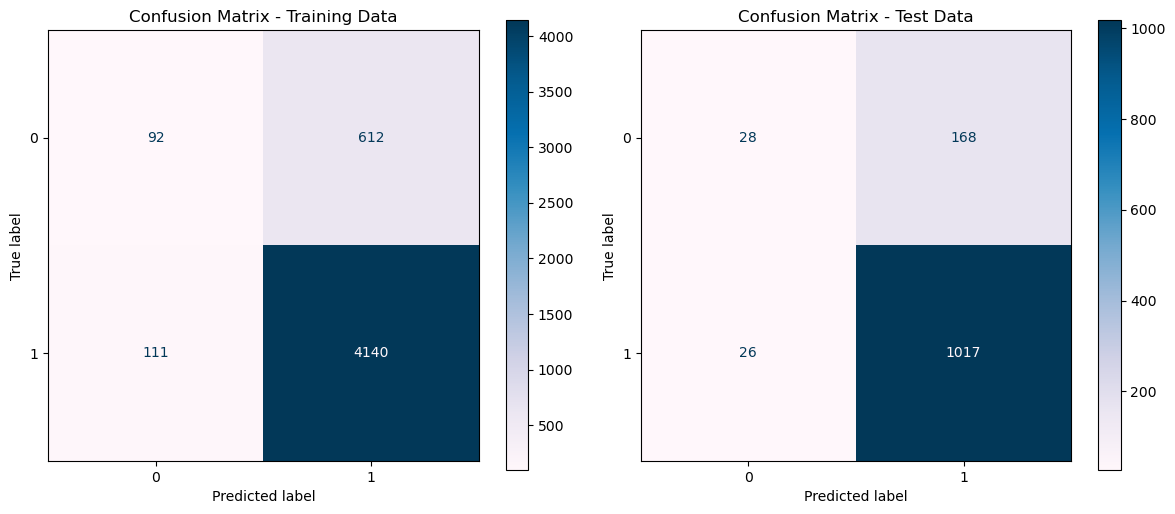

In [56]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for training data
train_matrix = ConfusionMatrixDisplay.from_estimator(pipe_logreg, X_train, y_train, cmap='PuBu', ax=axes[0])
train_matrix.ax_.set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for test data
test_matrix = ConfusionMatrixDisplay.from_estimator(pipe_logreg, X_test, y_test, cmap='PuBu', ax=axes[1])
test_matrix.ax_.set_title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

Dapat terlihat model bisa memprediksi kelas Deny or Wailist dengan akurat, hal ini karena mayoritas data adalah kelas ini merupakan mayoritas. Meskipun jumlah data kelas Admit memang sedikit sehingga yang diprediksi benar juga juga jauh lebih sedikit, terlihat bahwa ada banyak sekali kesalahan. Model memprioritaskan nilai Recall, sehingga ingin meminimalisir jumlah calon mahasiswa layak yang diprediksi sebagai Deny. Model ini masih kurang bagus karena mayoritas mahasiswa yang layak untuk diterima diprediksikan sebagai Deny.

## B. Model Optimization

Performa model ingin ditingkatkan dengan menentukkan hyperparameter yang tepat. Penentuan ini bisa dengan menggunakan GridSearchCV

In [57]:
# Set up the parameter

param_grid_lr = {
    'classifier__C': [1, 10, 100],
    'classifier__penalty': ['l2', 'l1'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__max_iter': [100, 200, 500],
    'classifier__class_weight': [None, 'balanced']
}

# Set up the GridSearchCV object for Random Forest
grid_search_lr = GridSearchCV(pipe_logreg,
                                    param_grid=param_grid_lr,
                                    scoring='recall',
                                    cv=skfold,
                                    verbose=2,
                                    n_jobs=-1)

# Fit GridSearchCV for Logistic Regression
grid_search_lr.fit(X_train, y_train)

# Best hyperparameters for logreg
print('Best hyperparameters for Logistic Regression:', grid_search_lr.best_params_)

# Best recall for Logistic Regression
print('Best recall for Logistic Regression:', grid_search_lr.best_score_)

# Save best Logistic Regression model to a variable
best_lr_model = grid_search_lr.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyperparameters for Logistic Regression: {'classifier__C': 1, 'classifier__class_weight': None, 'classifier__max_iter': 100, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best recall for Logistic Regression: 0.9734167415497339


### Model evaluation after tuning

Evaluasi model yang telah di hyperparameter tuning

In [58]:
# Get predictions for training and testing set using the hyperparameter tuned model
y_pred_train_tuned = best_lr_model.predict(X_train)
y_pred_test_tuned = best_lr_model.predict(X_test)
# Print auc score
print('AUC Score - Train Set  : ', roc_auc_score(y_train, y_pred_train_tuned))
print('AUC Score - Test Set   : ', roc_auc_score(y_test, y_pred_test_tuned))

AUC Score - Train Set  :  0.5515749302303202
AUC Score - Test Set   :  0.5589645254074784


In [59]:
# Print recall score
print('Recall Score - Train Set  : ', recall_score(y_train, y_pred_train_tuned))
print('Recall Score - Test Set   : ', recall_score(y_test, y_pred_test_tuned))

Recall Score - Train Set  :  0.9738884968242767
Recall Score - Test Set   :  0.975071907957814


In [60]:
print(classification_report(y_test, best_lr_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.52      0.14      0.22       196
           1       0.86      0.98      0.91      1043

    accuracy                           0.84      1239
   macro avg       0.69      0.56      0.57      1239
weighted avg       0.80      0.84      0.80      1239



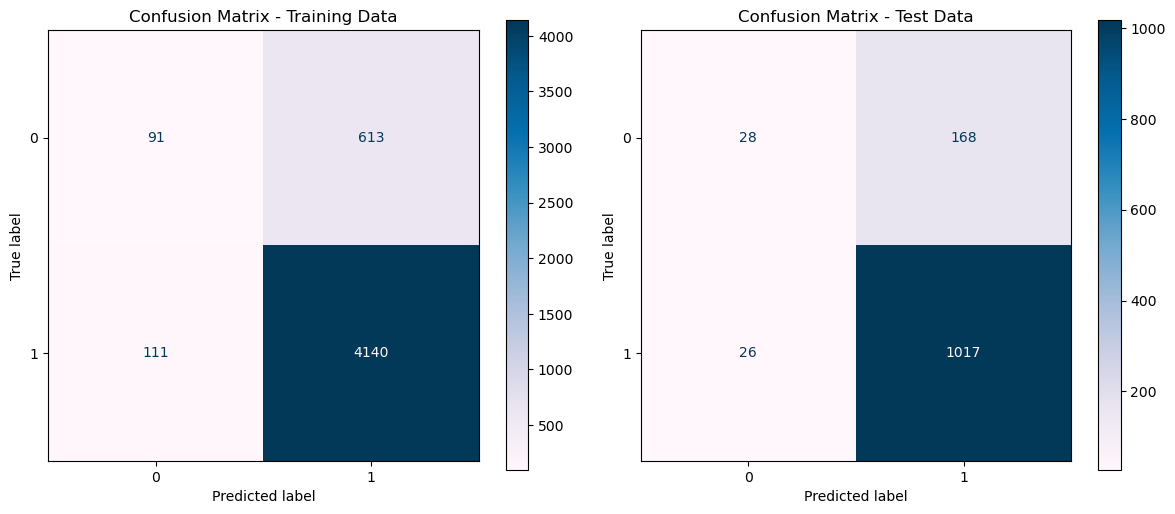

In [61]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for training data
train_matrix = ConfusionMatrixDisplay.from_estimator(best_lr_model, X_train, y_train, cmap='PuBu', ax=axes[0])
train_matrix.ax_.set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for test data
test_matrix = ConfusionMatrixDisplay.from_estimator(best_lr_model, X_test, y_test, cmap='PuBu', ax=axes[1])
test_matrix.ax_.set_title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

Perbandingan antara model sebelum dan sesudah Tuning

In [62]:
def evaluate_model(y_train, y_pred_train, y_test, y_pred_test):
    auc_train = roc_auc_score(y_train, y_pred_train)
    auc_test = roc_auc_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    
    report = classification_report(y_test, y_pred_test, output_dict=True)
    recall_per_class = {f"Recall Class {k}": v["recall"] for k, v in report.items() if k not in ["accuracy", "macro avg", "weighted avg"]}
    
    return {
        "AUC Score (Train)": auc_train,
        "AUC Score (Test)": auc_test,
        "Recall Score (Train)": recall_train,
        "Recall Score (Test)": recall_test,
        **recall_per_class
    }

In [63]:
# Evaluasi model sebelum tuned
eval_model = evaluate_model(y_train, y_pred_train, y_test, y_pred_test)
# Evaluasi model setelah tuned
eval_model_tuned = evaluate_model(y_train, y_pred_train_tuned, y_test, y_pred_test_tuned)
# Membuat tabel perbandingan
comparison_table = pd.DataFrame([eval_model, eval_model_tuned], index=["Model", "Model Tuned"]).T

# Cetak tabel perbandingan
comparison_table

,Model,Model Tuned
AUC Score (Train),0.552285,0.551575
AUC Score (Test),0.558965,0.558965
Recall Score (Train),0.973888,0.973888
Recall Score (Test),0.975072,0.975072
Recall Class 0,0.142857,0.142857
Recall Class 1,0.975072,0.975072


Sama persis dengan sebelum tuned:
- Nilai AUC rendah, model belum bisa membedakan antar kelas dengan baik
- Model bias ke kelas mayoritas yaitu Deny or Waitlist, prediksi jauh lebih baik untuk kelas ini saja
- Nilai False Positive untuk kelas Admit jauh lebih tinggi dari True Positive

Karena hyperparameter tuning tidak bisa mengatasi masalah ini, maka akan dilakukan Data Balancing oversampling menggunakan metode SMOTE, memberi bobot yang lebih besar untuk kelas yang berjumlah kecil

### Data Balancing

Karena hasil sebelumnya belum memuaskan, dilakukan data balancing untuk meningkatkan nilai recall di kelas Admit dan menyeimbangkan recall untuk kedua kelas, dan dilanjutkan dengan hyperparameter tuning dari data yang sudah seimbang

In [64]:
# inisialisasi SMOTENC untuk melakukan Oversampling
smote = SMOTENC(categorical_features=[0, 2], random_state=42)
pipe_lr_smote = imPipeline(steps=[
    ('transformer', transformer),
    ('smote', smote),
    ('classifier',
    LogisticRegression(solver='liblinear', max_iter=1000000))])

# Set up GridSearchCV for Logistic Regression with SMOTE
grid_search_lr_smote = GridSearchCV(pipe_lr_smote,
                                    param_grid=param_grid_lr,
                                    scoring='recall_weighted',  # Focus on recall
                                    cv=skfold,
                                    verbose=2,
                                    n_jobs=-1)

# Fit GridSearchCV for Logistic Regression with SMOTE
grid_search_lr_smote.fit(X_train, y_train)

# Best hyperparameters for Logistic Regression with SMOTE
print('Best hyperparameters for Logistic Regression with SMOTE:', grid_search_lr_smote.best_params_)

# Best recall for Logistic Regression with SMOTE
print('Best recall for Logistic Regression with SMOTE:', grid_search_lr_smote.best_score_)

# Save best Logistic Regression model to a variable
best_lr_model_smote = grid_search_lr_smote.best_estimator_

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best hyperparameters for Logistic Regression with SMOTE: {'classifier__C': 100, 'classifier__class_weight': None, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best recall for Logistic Regression with SMOTE: 0.7368314833501514


Nilai recall 0.73, terdapat penurunan nilai recall dari data sebelum balancing yang bernilai 0.97

# **VIII. Model Evaluation**

Periksa nilai AUC Score dan Recall

In [65]:
# Get predictions for training and testing set using the hyperparameter tuned model
y_pred_train_balanced = best_lr_model_smote.predict(X_train)
y_pred_test_balanced = best_lr_model_smote.predict(X_test)

#auc score
print('AUC Score - Train Set  : ', roc_auc_score(y_train, y_pred_train_balanced))
print('AUC Score - Test Set   : ', roc_auc_score(y_test, y_pred_test_balanced))

AUC Score - Train Set  :  0.7433839096683134
AUC Score - Test Set   :  0.7436481303930969


In [66]:
# Print recall score
print('Recall Score - Train Set  : ', recall_score(y_train, y_pred_train_balanced))
print('Recall Score - Test Set   : ', recall_score(y_test, y_pred_test_balanced))

Recall Score - Train Set  :  0.7367678193366267
Recall Score - Test Set   :  0.7372962607861937


- Dari nilai AUC model bisa membedakan sekitar 74% dari data test dengan benar, model ini bisa dinilai cukup bagus

- Nilai recall juga kurang lebih sama, model bisa mendeteksi 74% kelas Admit (True Positive) dengan benar

In [67]:
eval_model_balance = evaluate_model(y_train, y_pred_train_balanced, y_test, y_pred_test_balanced)

comparison_table = pd.DataFrame([eval_model_tuned, eval_model_balance], index=["Model Tuned", "Model Balanced"]).T
comparison_table

,Model Tuned,Model Balanced
AUC Score (Train),0.551575,0.743384
AUC Score (Test),0.558965,0.743648
Recall Score (Train),0.973888,0.736768
Recall Score (Test),0.975072,0.737296
Recall Class 0,0.142857,0.750000
Recall Class 1,0.975072,0.737296


- Setelah balancing, AUC meningkat signifikan menjadi 0.74 pada dataset train dan test. Ini menunjukkan bahwa model menjadi lebih baik dalam membedakan antara kelas 0 dan kelas 1, tanpa bias terlalu besar pada satu kelas tertentu.

- Terjadi penurunan pada Recall Score keseluruhan untuk data balanced, tetapi jarak antara Recall Train dan Test lebih dekat pada model balanced. Model balanced sedikit kurang overfit dari model Tuned

- Recall menjadi lebih seimbang antara kelas 0 (Admit) dan kelas 1 (Deny or Waitlist). Recall Kelas 0 adalah 75%, Ini adalah peningkatan signifikan dibandingkan dengan model sebelumnya (14.29%). Model lebih baik mendeteksi data dari kelas 0. Recall Kelas adalah 74%, ada penurunan recall pada kelas 1 dibandingkan model tanpa balancing, namun ini wajar karena model sekarang mencoba untuk lebih seimbang dalam memprediksi kedua kelas.


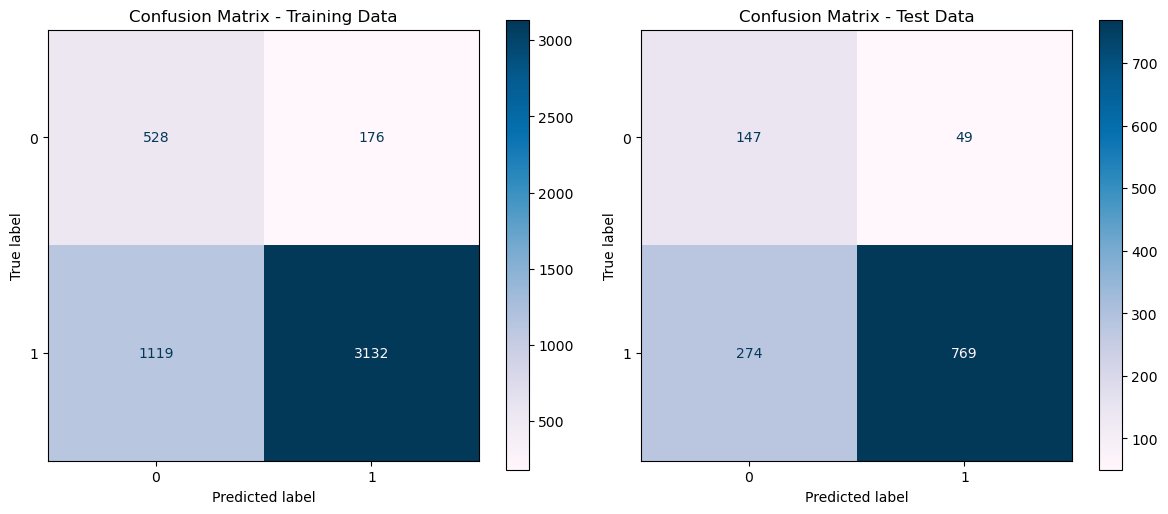

In [68]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for training data
train_matrix = ConfusionMatrixDisplay.from_estimator(best_lr_model_smote, X_train, y_train, cmap='PuBu', ax=axes[0])
train_matrix.ax_.set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for test data
test_matrix = ConfusionMatrixDisplay.from_estimator(best_lr_model_smote, X_test, y_test, cmap='PuBu', ax=axes[1])
test_matrix.ax_.set_title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

Model bisa memprediksi kedua kelas dengan baik. Walaupun ada beberapa kesalahan, mayoritas data bisa diprediksi dengan benar. Kebanyakan mahasiswa pada kelas Admit tidak terlewatkan dan diprediksi benar sebagai Admit, juga untuk Deny or Waitlist prediksinya sudah sesuai

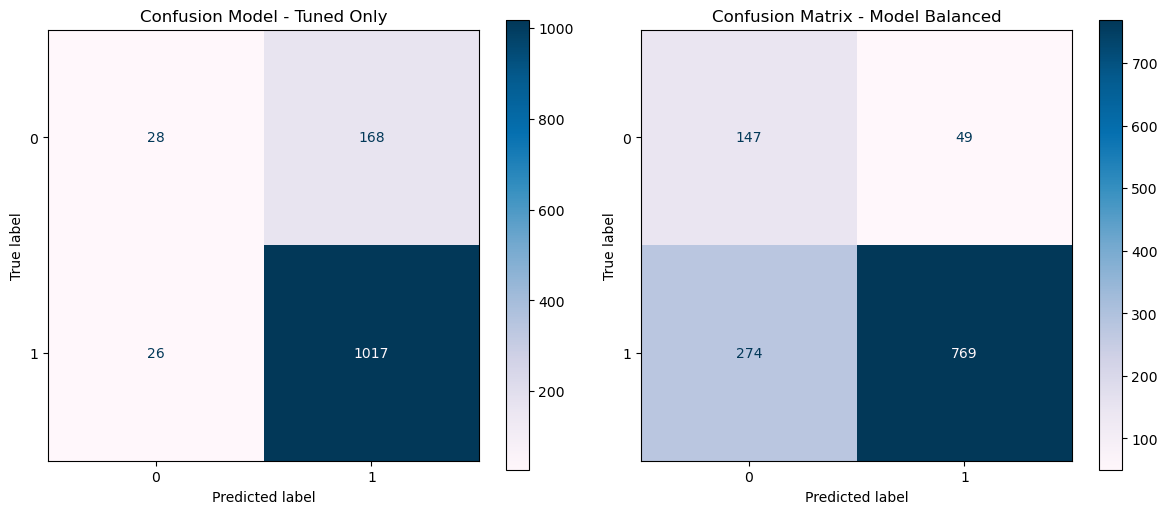

In [71]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for training data
train_matrix = ConfusionMatrixDisplay.from_estimator(best_lr_model, X_test, y_test, cmap='PuBu', ax=axes[0])
train_matrix.ax_.set_title('Confusion Model - Tuned Only')

# Plot confusion matrix for test data
test_matrix = ConfusionMatrixDisplay.from_estimator(best_lr_model_smote, X_test, y_test, cmap='PuBu', ax=axes[1])
test_matrix.ax_.set_title('Confusion Matrix - Model Balanced')

plt.tight_layout()
plt.show()

Dibandingkan dengan model sebelum balancing, dapat terlihat bahwa prediksi True Positive jauh lebih baik meskipun ada beberapa kesalahan, mayoritas data kelas Admit bisa dideteksi dengan benar. Kelas Deny or Waitlist juga masih cukup bagus mayoritas pada True Negatif, akan tetapi dibandingkan dengan model sebelum balancing, False Negative atau kesalahannya menjadi lebih banyak, terjadi penurunan nilai Recall pada kelas ini.

Overall

Kelebihan Model:
- Nilai Recall dan AUC mendekati satu sama lain dan juga tidak bernilai rendah, menunjukkan bahwa model tidak overfitting dan juga tidak underfitting
- Model lebih adil dalam memprediksi kedua kelas, terlihat dari nilai AUC yang meningkat dan Recall kelas 0 yang jauh lebih baik dibandingkan dengan hasil model lain.
- Nilai AUC dan Recall yang seimbang pada train dan test menunjukkan model memiliki generalisasi yang baik.
- Model bisa memprediksi True Positif atau kelas Admit yang jauh lebih baik dari model lain, menunjukkan bahwa model paling cocok dipakai untuk kasus ini

Kekurangan Model:
- Recall kelas 1 menurun dibandingkan model yang hanya dituned. Namun, ini trade-off yang wajar karena balancing bertujuan untuk meningkatkan performa model secara keseluruhan.

Dari analisis ini dapat disimpulkan bahwa model telah memenuhi keperluan dari perhitungan metricnya:
- Untuk AUC score: Model dapat membedakan kedua kelas dengan cukup baik
- Untuk  Recall score: Model dapat memprediksi kelas Admit atau label True Positive dengan baik dan berhasil meminimalisir nilai False Positive

# **IX. Model Saving**

Menyimpan model yang sudah dibuat dalam file

In [70]:
# Save the best model
with open('best_lr_model_smote.pkl', 'wb') as model_file:
  pickle.dump(best_lr_model_smote, model_file)

# **X. Pengambilan Kesimpulan**

## EDA

Dari penjabaran Objective yang ingin dicapai:

**1. Calon mahasiswa**
- Calon mahasiswa dengan skor GMAT yang tinggi (di atas rata-rata 651) memiliki kemungkinan lebih besar untuk diterima. Skor GMAT terbukti menjadi faktor signifikan dalam menentukan status admission dibandingkan GPA.
- GPA juga memainkan peran penting, meskipun pengaruhnya sedikit lebih kecil dibandingkan GMAT. Mayoritas calon mahasiswa memiliki GPA tinggi, menunjukkan kompetisi yang ketat.

Hasil analisis EDA dapat membantu calon mahasiswa memahami pentingnya meningkatkan skor GMAT mereka, dan juga mempertahankan GPA yang tinggi, supaya dapat meningkatkan peluang diterima. Tahun pengalaman kerja dan industrinya tidak menjadi faktor utama, sehingga lebih baik fokus pada kualifikasi akademik dan persiapan ujian GMAT yang sebaiknya.


**2. Tim Admission**

Hasil analisis EDA menyajikan informasi bahwa:
- Sebagian besar calon mahasiswa adalah laki-laki, menunjukkan bahwa ada potensi kesenjangan gender yang mungkin dapat menjadi perhatian dalam strategi perekrutan.
- Meskipun pilihan jurusan relatif seimbang, pengalaman kerja dalam industri tertentu seperti Consulting menjadi yang paling banyak, diikuti oleh PE/VC dan Technology.
- Ras calon mahasiswa menunjukkan distribusi yang cukup beragam, namun dengan dominasi pada ras Caucasian.
- Industri tempat calon mahasiswa bekerja tidak memiliki hubungan signifikan dengan jurusan yang mereka pilih.

Analisis ini membantu tim memahami celah dari proses seleksi sekarang, walaupun nilai GMAT dan GPA bisa jadi fokus utama, faktor lain seperti pengalaman kerja juga menjadi pengaruh terhadap penerimaan. Tingkatkan inklusivitas dengan  mempertimbangkan faktor-faktor non-akademik yang dapat memengaruhi keberhasilan calon mahasiswa diterima di program studi. Selain itu, distribusi gender dan ras memberikan wawasan untuk meningkatkan keberagaman di perekrutan universitas ini.


## Model
**Data Scientist/Analyst**

Penggunaan data sintesis dapat menjadi latihan pembuatan model machine learning. Dari pembuatan model ini dapat mengasah kemampuan analisis, feature engineering, dan juga pembuatan model terutama untuk penggunaan Pipeline dan data balancing. Model yang dibuat melalui proses data balancing dan hyperparameter tuning, hasilnya:

Kelebihan:
- Skor AUC dan Recall yang bernilai tidak rendah dan hampir sama di data train dan test menunjukkan bahwa model bisa membedakan kelas dengan baik dan tidak mengalami overfitting atau underfitting yang signifikan.
- Skor Recall per kelas juga menunjukkan hasil yang cukup baik untuk kelas Admit (0.75) dan kelas Deny or Waitlist (0.74), yang berarti model telah memenuhi keperluan untuk memprioritas nilai Recall. Mayoritas kelas Admit menghasilkan True Positive, dan nilai False Positive minim, atau mayoritas calon mahasiswa yang layak dapat dideteksi sebagai diterima

Kekurangan:
- AUC 0.74 menandakan bahwa model hanya memiliki kemampuan sedang saja dalam membedakan antara dua kelas. Ada potensi untuk meningkatkan pembedaan ini.
- Meski cukup baik, recall sekitar 0.73–0.75 menunjukkan masih ada ruang untuk meningkatkan performa model, terutama pada kelas Deny or Waitlist.

Improvement:
- Seimbangkan data dengan data asli dan bukan sintesis seperti SMOTE saja, dengan begitu nilai AUC dan Recall bisa ditingkatkan
- Percobaan menggunakan Class Weighting, dalam proses klasifikasi memberikan bobot yang lebih besar pada kelas minoritas.
- Memperbaiki proses feature engineering, contohnya di feature selection, menghapus semua korelasi yang di bawah 0.5
- Mencari model lain yang lebih kompleks untuk menangani data ini

# Conceptual Problems

## 1. Bagging
Bagging dibuat untuk mengatasi masalah overfitting dan variance tinggi pada model machine learning, terutama pada algoritma yang terkenal sering terjadi masalah ini contohnya seperti Decision Tree karena sensitif terhadap varian data. Metode ini didasarkan pada gagasan bahwa menggabungkan prediksi dari beberapa model dapat meningkatkan akurasi dan stabilitas prediksi. Terdapat 3 langkah:
- Membuat beberapa subset data training berukuran yang sama dengan mengambil sampel secara acak.
- Membuat model pada setiap subset sampling yang telah dibuat
- Semua prediksi digabungkan. Untuk regresi menggunakan rata - rata, untuk klasifikasi menggunakan voting mayoritas

## 2. Perbedaan Random Forest dengan XGBoost
-  Pendekatan: Random Forest menggunakan teknik bagging sedangkan XGBoost menggunakan teknik boosting

-  Sifat: Random Forest bersifat paralel (pohon dibangun secara independen) sedangkan XGBoost bersifat serial (model dibangun satu per satu secara berurutan)

- Overfitting: Random Forest lebih cocok untuk menghidari overfitting, sedangkan XGBoost perlu tuning lanjut untuk mencegahnya

- Tujuan: Random Forest untuk mengurangi variance, sedangkan XGBoost untuk mengurangi bias dan variance, juga meningkatkan akurasi

## 3. Crossvalidation

Cross Validation adalah teknik evaluasi performa model machine learning dengan membagi dataset menjadi beberapa subset (folds) untuk proses training dan testing. Proses training dan testing ini dilakukan beberapa kali sesuai kebutuhan, hasil evaluasi dari setiap iterasi dirata-rata untuk memberikan metric performa model. Teknik ini dipakai untuk menghindari bias dalam evaluasi model (overfitting atau underfitting), mengukur kinerja model secara akurat pada data yang belum dilihat model, memastikan bahwa model diuji pada berbagai bagian dataset.